# Settings

In [42]:
from pathlib import Path

import numpy as np
from scipy import stats as sp_stats
import pandas as pd
pd.plotting.register_matplotlib_converters()
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sb

In [43]:
syntanic_data_path = Path(r'.\data\train.csv')
syntanic_data = pd.read_csv(syntanic_data_path, index_col='PassengerId')
ports_of_embarkation = ['Southampton', 'Cherbourg', 'Queenstown']
syntanic_data['Embarked'].replace(
      {p[0]: p for p in ports_of_embarkation},
      inplace=True)

syntanic_data['Relatives'] = syntanic_data['SibSp'] + syntanic_data['Parch']
syntanic_data['CabinPrefix'] = syntanic_data['Cabin'].str[0]

syntanic_data.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relatives,CabinPrefix
PassengerId,,,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,Southampton,2,C
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,Southampton,0,NaN
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,Southampton,3,NaN
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,Southampton,0,NaN
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,Southampton,0,NaN
5,0,2,"Sassano, Jonathan",male,35.00,0,0,13363,6.71,NaN,Southampton,0,NaN
6,0,3,"Conway, Jose",male,7.00,0,0,A/5,9.77,NaN,Southampton,0,NaN
7,1,3,"Werner, Linda",female,6.00,1,2,434426,31.50,NaN,Southampton,3,NaN
8,0,1,"Wardlaw, Michael",male,27.00,2,1,474849,73.02,A7253,Southampton,3,A


# Context

Здесь использован синтетический набор данных, но основан на реальных данных с Титаника.

В данных следующие колонки: ``` ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'] ```, а ```'PassengerId'``` использован как индекс строки.

#### Data dictionary:
```'PassengerId'``` -- ID пассажира
```Survived``` -- показывает, выжил ли пассажир или нет (1 -- Yes, 0 -- No)
```Pclass``` -- класс пассажира (1 -- 1 класс (наивысший), 2 -- средний, 3 -- низкий (эконом?))
```Name``` -- имя пассажира (формат: ИМЯ, ФАМИЛИЯ)
```Sex``` -- пол пассажира
```Age``` -- возраст пассажира
```SibSp``` (<b>Sib</b>ling, <b>Sp</b>ouse) -- количество братьев и сестер на кораболе или наличие мужа или жены на корабле
```Parch``` (<b>Par</b>ent, <b>Ch</b>ild) -- количество родителей или детей на корабле
```Ticket``` -- номер билета
```Fare``` -- стоимость тарифа
```Cabin``` -- номер каюты
```Embarked``` -- Порт назначения (C -- Cherbourg, Q -- Queenstown, S -- Southampton)

#### Добавленные колонки:
```Relatives``` -- количество родственников на корабле
```CabinPrefix``` -- префикс номера каюты

В ходе изучения данных выдвинуто предположение, что основной целью является выявление степени влияния различных параметров на вероятность выживания пассажира. Однако это не отбрасывает интерес к зависимостям между другими параметрами

# Data quality assessment

In [44]:
par_total_rows = syntanic_data.shape[0]
par_total_cols = syntanic_data.shape[1]
par_dtypes_dict = {}
for col_name in syntanic_data:
      par_dtypes_dict[col_name] = syntanic_data[col_name].dtype.name

print('Количество строк (пассажиров) в данных {:d}, '
      'количество колонок - {:d}. '
      'В каждой из колонок данные следующих типов:\n{}\n'
      'При импорте сокращенные названия портов назначения '
      'были заменены на полные. Однако правдивость данных '
      'в представленных колонках следует исследовать отдельно '
      '(например нахождение всех родственников по фамилии)'
      .format(par_total_rows, par_total_cols, '\n'.join(
      f'\'{k}\' - {v}' for k, v in par_dtypes_dict.items())))

Количество строк (пассажиров) в данных 100000, количество колонок - 13. В каждой из колонок данные следующих типов:
'Survived' - int64
'Pclass' - int64
'Name' - object
'Sex' - object
'Age' - float64
'SibSp' - int64
'Parch' - int64
'Ticket' - object
'Fare' - float64
'Cabin' - object
'Embarked' - object
'Relatives' - int64
'CabinPrefix' - object
При импорте сокращенные названия портов назначения были заменены на полные. Однако правдивость данных в представленных колонках следует исследовать отдельно (например нахождение всех родственников по фамилии)


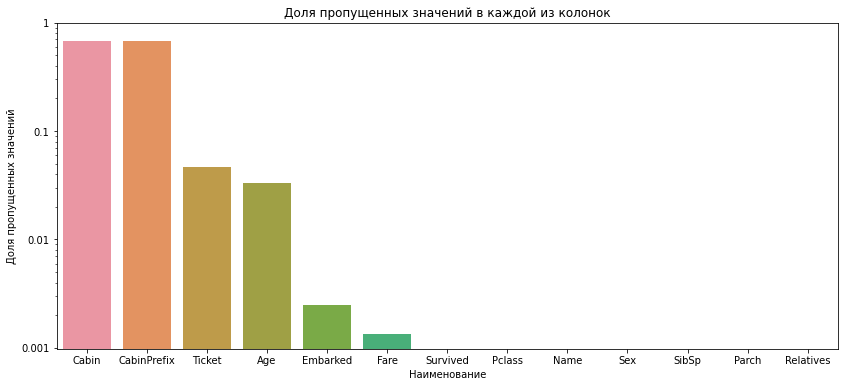

Среди колонок наибольшее количество пропущенных значений имеет номер кабины ('Cabin' = 67.87%), далее номер билета ('Ticket' = 4.62%) и возраст ('Age' = 3.29%), а наименьшее - порт назначения ('Embarked' = 0.25%) и тариф ('Fare' = 0.13%). В остальных колонках нет пропущенных значений.
При этом во всем датасете обнаружено 0 полностью пустых строк


In [45]:
plt.figure(figsize=(14, 6))
plt.title('Доля пропущенных значений в каждой из колонок')

na_fraction = (syntanic_data.isna().sum() / par_total_rows).sort_values(ascending=False)
na_frac_fig = sb.barplot(x=na_fraction.index, y=na_fraction)
na_frac_fig.set(xlabel='Наименование', ylabel='Доля пропущенных значений')
na_frac_fig.set_yscale("log")
na_frac_fig.set_yticks([0.001, 0.01, 0.1, 1])
na_frac_fig.set_yticklabels([0.001, 0.01, 0.1, 1])
plt.show()

print('Среди колонок наибольшее количество пропущенных значений имеет '
      'номер кабины (\'Cabin\' = {:.2%}), далее номер билета '
      '(\'Ticket\' = {:.2%}) и возраст (\'Age\' = {:.2%}), '
      'а наименьшее - порт назначения (\'Embarked\' = {:.2%}) '
      'и тариф (\'Fare\' = {:.2%}). В остальных колонках '
      'нет пропущенных значений.'\
      .format(na_fraction['Cabin'], na_fraction['Ticket'], na_fraction['Age'],
              na_fraction['Embarked'], na_fraction['Fare']))
print('При этом во всем датасете обнаружено {:d} полностью пустых строк'
      .format(par_total_rows - syntanic_data.dropna(how='all').shape[0]))

Датасет имеет 0 строк-дубликатов


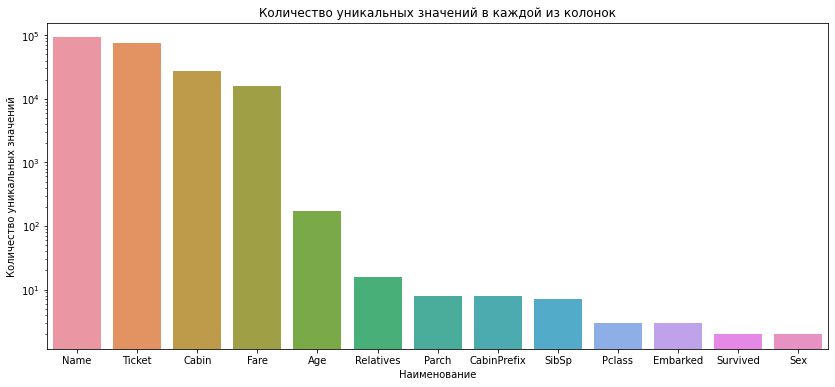

При расчете отсутвующие значения отбрасывались. Среди данных уникальных имен 92144, номеров билетов 75331 (самый часто встречающийся билет - 'A/5 ' (601 раз)), номеров кают 26992 (что логично, так как каюты бывают многоместные и также в этих данных больше всего отсутствующих значений)
Обычно подразумевается, что билет имеет уникальный номер. Поэтому делается предположение, что в этом поле много невалидных данных. В дальнейшем обработка может проводиться только по уникальным номерам билетов (о чем будет написано)


In [46]:
print('Датасет имеет {:d} строк-дубликатов'\
      .format(syntanic_data[syntanic_data.duplicated()].shape[0]))

plt.figure(figsize=(14, 6))
plt.title('Количество уникальных значений в каждой из колонок')

unique_values_count = syntanic_data.nunique(dropna=True).sort_values(ascending=False)
unique_vals_fig = sb.barplot(x=unique_values_count.index, y=unique_values_count)
unique_vals_fig.set(xlabel='Наименование', ylabel='Количество уникальных значений')
unique_vals_fig.set_yscale("log")
plt.show()

duplicated_tickets = syntanic_data['Ticket'].dropna()[syntanic_data['Ticket']\
      .dropna().duplicated()].value_counts()

print('При расчете отсутвующие значения отбрасывались. '
      'Среди данных уникальных имен {:d}, номеров билетов {:d} '
      '(самый часто встречающийся билет - \'{}\' ({:d} раз)), '
      'номеров кают {:d} (что логично, так как каюты бывают '
      'многоместные и также в этих данных больше всего '
      'отсутствующих значений)'\
      .format(unique_values_count['Name'], unique_values_count['Ticket'],
              duplicated_tickets.idxmax(), duplicated_tickets.max(),
              unique_values_count['Cabin']))

print('Обычно подразумевается, что билет имеет уникальный номер. Поэтому делается '
      'предположение, что в этом поле много невалидных данных. В дальнейшем обработка '
      'может проводиться только по уникальным номерам билетов (о чем будет написано)')

In [47]:
par_outliner_col_names = ['Age', 'SibSp', 'Parch', 'Fare']
par_outliners_dict = {}
for col_name in par_outliner_col_names:
      par_outliners_dict[col_name] = syntanic_data[
            (sp_stats.zscore(syntanic_data[col_name]) > 3) & (syntanic_data[col_name] != 0)].shape[0]

print('В колонках {} обнаружены следующее кол-во выбросов '
      '(выброс определялся по z-score > 3)\n{}\n'
      'Так как многие из пассажиров находились на корабле '
      'без родственников, то при рассчете z-score они не учитывались.\n'
      'Максимальные значения для \'SibSp\' - 2, \'Parch\' - 3. '
      'Так как предполагается, что количество родственников носит '
      'случайный характер, то полученные результаты не будут учитываться '
      'и будет считаться, что в данных отсутствуют выбросы.'
      .format(
      ', '.join(par_outliner_col_names),
      '\n'.join(f'\'{k}\' - {v}' for k, v
                in par_outliners_dict.items())))

В колонках Age, SibSp, Parch, Fare обнаружены следующее кол-во выбросов (выброс определялся по z-score > 3)
'Age' - 0
'SibSp' - 3231
'Parch' - 1245
'Fare' - 0
Так как многие из пассажиров находились на корабле без родственников, то при рассчете z-score они не учитывались.
Максимальные значения для 'SibSp' - 2, 'Parch' - 3. Так как предполагается, что количество родственников носит случайный характер, то полученные результаты не будут учитываться и будет считаться, что в данных отсутствуют выбросы.


# Data exploration

In [48]:
par_males_count = syntanic_data[(syntanic_data['Sex'] == 'male')].shape[0]
par_males_alive = syntanic_data[
                        (syntanic_data['Sex'] == 'male') & (syntanic_data['Survived'] == 1)
                  ].shape[0] / par_males_count
par_females_count = syntanic_data[(syntanic_data['Sex'] == 'female')].shape[0]
par_female_alive = syntanic_data[
                         (syntanic_data['Sex'] == 'female') & (syntanic_data['Survived'] == 1)
                   ].shape[0] / par_females_count

par_1st_count = syntanic_data[syntanic_data['Pclass'] == 1].shape[0] / par_total_rows
par_2st_count = syntanic_data[syntanic_data['Pclass'] == 2].shape[0] / par_total_rows
par_3st_count = syntanic_data[syntanic_data['Pclass'] == 3].shape[0] / par_total_rows

par_fare_mean = syntanic_data['Fare'].mean()

par_age_mean = syntanic_data['Age'].mean()
par_age_mean_alive = syntanic_data[
      syntanic_data['Survived'] == 1]['Age'].mean()
par_age_mean_ns = syntanic_data[
      syntanic_data['Survived'] == 0]['Age'].mean()

par_relative = syntanic_data[
      (syntanic_data['Parch'] != 0) & (syntanic_data['SibSp'] != 0)
].shape[0]


print('Сводка по данным (пассажирам):\n'
      '- Среди пассажиров {:.2%} мужчин;\n'
      '- {:.2%} пассажиров 1 класса, 2 класса {:.2%} пасс., '
      '3 класса {:.2%} пасс.'.format(
      par_males_count / par_total_rows, par_1st_count, par_2st_count, par_3st_count
))

print('- Средний возраст пассажиров {:.2f} лет\n'
      '- Средний возраст выживших и погибших {:.2f} лет и {:.2f} лет, соотв.\n'
      '- Среди выживших пассажиров {:.2%} мужчин, женщин - {:.2%}'
      .format(par_age_mean, par_age_mean_alive, par_age_mean_ns,
      par_males_alive, par_female_alive))

print('- {} пассажиров имеют родственников на корабле'
      .format(par_relative))

print('- Средняя стоимость тарифа составляет {:.2f} (максимум {:.2f})'\
      .format(par_fare_mean,
              syntanic_data['Fare'].max()
))

Сводка по данным (пассажирам):
- Среди пассажиров 56.11% мужчин;
- 30.31% пассажиров 1 класса, 2 класса 28.68% пасс., 3 класса 41.01% пасс.
- Средний возраст пассажиров 38.36 лет
- Средний возраст выживших и погибших 40.55 лет и 36.71 лет, соотв.
- Среди выживших пассажиров 20.58% мужчин, женщин - 71.15%
- 15005 пассажиров имеют родственников на корабле
- Средняя стоимость тарифа составляет 43.93 (максимум 744.66)


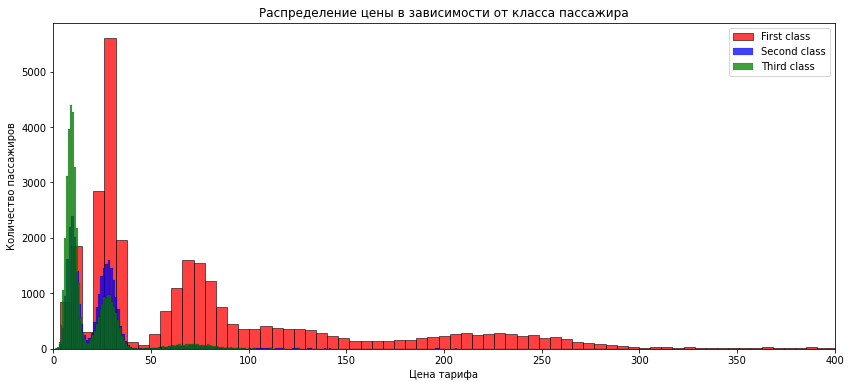

Самая частая стоимость тарифа среди пассажиров 1 класса около 29,2 класса - около 28, 3 класса - 9,5. На гистограмме имеется три ярковыраженных пика для всех трех классов, что скорее всего зависит от порта назначения


In [49]:
plt.figure(figsize=(14, 6))
plt.title('Распределение цены в зависимости от класса пассажира')

class_price_fig: plt.Axes = sb.histplot(
      data=syntanic_data[syntanic_data['Pclass'] == 1]['Fare'], label='First class',
      color='Red'
)
sb.histplot(
      data=syntanic_data[syntanic_data['Pclass'] == 2]['Fare'], label='Second class',
      color='Blue'
)
sb.histplot(
      data=syntanic_data[syntanic_data['Pclass'] == 3]['Fare'], label='Third class',
      color='Green'
)

class_price_fig.set(xlabel='Цена тарифа', ylabel='Количество пассажиров')
class_price_fig.set_xlim(0, 400)
plt.legend()
plt.show()

print(f'Самая частая стоимость тарифа среди пассажиров 1 класса около 29,'
      f'2 класса - около 28, 3 класса - 9,5. На гистограмме имеется три '
      f'ярковыраженных пика для всех трех классов, что скорее всего зависит '
      f'от порта назначения')

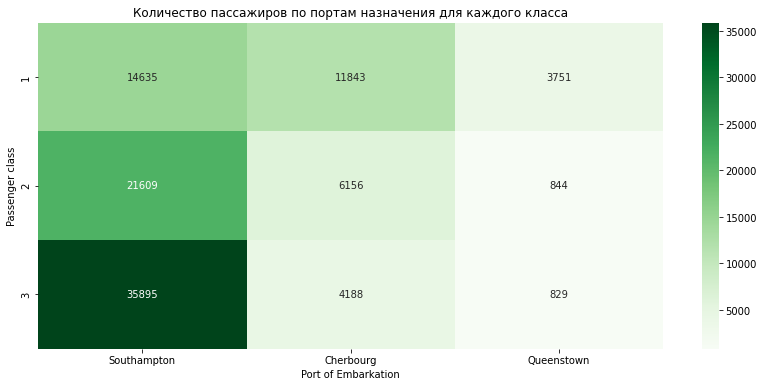

Из рисунка видно, что большинство пассажиров всех классов плывет в порт назначения Southampton


In [50]:
plt.figure(figsize=(14, 6))
plt.title('Количество пассажиров по портам назначения для каждого класса')

class_emdraked_count_data = pd.DataFrame(
      index=range(1, 4), columns=ports_of_embarkation,
      dtype=np.uint32
)
class_emdraked_count_data.rename_axis('Passenger class', inplace=True)

for column_name in class_emdraked_count_data:
      for row_index in class_emdraked_count_data[column_name].index:
          class_emdraked_count_data[column_name].loc[row_index] = \
                syntanic_data[
                      (syntanic_data['Embarked'] == column_name) &
                      (syntanic_data['Pclass'] == row_index)].shape[0]

class_emdraked_fare_fig_mean = sb.heatmap(
      data=class_emdraked_count_data, annot=True, fmt='.0f', cmap='Greens')
class_emdraked_fare_fig_mean.set_xlabel('Port of Embarkation')
plt.show()

print(f'Из рисунка видно, что большинство пассажиров всех классов плывет '
      f'в порт назначения Southampton')

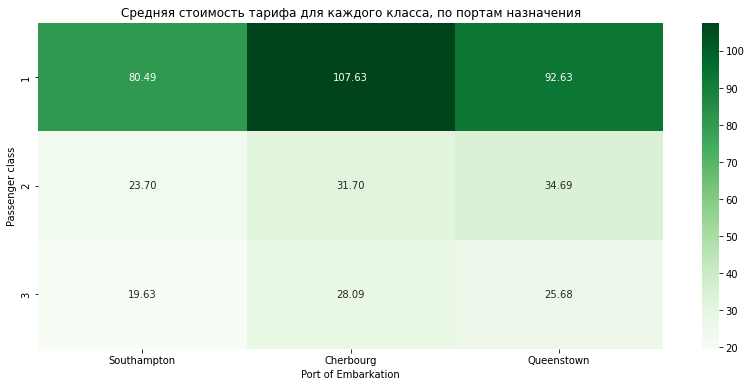

Как видно на рисунке наибольшая средняя стоимость у первого класса, при этом наибольшая средняя стоимость наблюдается для порта назначения Cherbourg (кроме 2 класса)


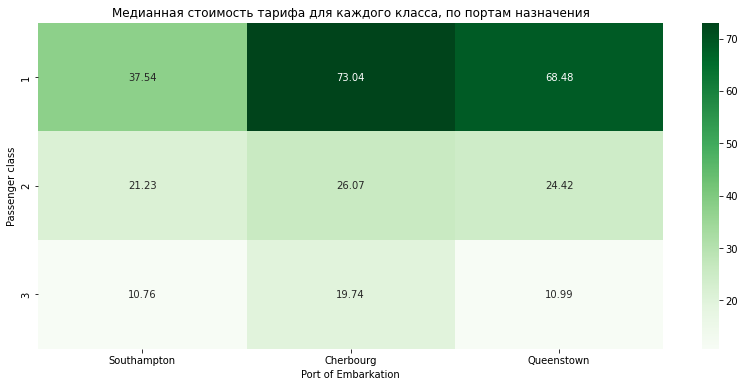

При рассмотрении медианной стоимости наблюдаются отличия. В этом случае более явно видна большая стоимость тарифа до порта назначения Cherbourg. Если сделать логичное предположение, что стоимость зависит от пути, то можно сделать вывод, что путь до Cherbourg наибольший


In [51]:
class_emdraked_fare_data_mean = pd.DataFrame(
      index=range(1, 4), columns=ports_of_embarkation,
      dtype=np.float_
)
class_emdraked_fare_data_mean.rename_axis('Passenger class', inplace=True)

for column_name in class_emdraked_fare_data_mean:
      for row_index in class_emdraked_fare_data_mean[column_name].index:
          class_emdraked_fare_data_mean[column_name].loc[row_index] = \
                syntanic_data[
                      (syntanic_data['Embarked'] == column_name) &
                      (syntanic_data['Pclass'] == row_index)]\
                      ['Fare'].mean()

class_emdraked_fare_data_median = pd.DataFrame(
      index=range(1, 4), columns=ports_of_embarkation,
      dtype=np.float_
)
class_emdraked_fare_data_median.rename_axis('Passenger class', inplace=True)

for column_name in class_emdraked_fare_data_median:
      for row_index in class_emdraked_fare_data_median[column_name].index:
          class_emdraked_fare_data_median[column_name].loc[row_index] = \
                syntanic_data[
                      (syntanic_data['Embarked'] == column_name) &
                      (syntanic_data['Pclass'] == row_index)]\
                      ['Fare'].median()

plt.figure(figsize=(14, 6))
plt.title('Средняя стоимость тарифа для каждого класса, по портам назначения')

class_emdraked_fare_fig_mean = sb.heatmap(
      data=class_emdraked_fare_data_mean, annot=True, fmt='.2f', cmap='Greens')
class_emdraked_fare_fig_mean.set_xlabel('Port of Embarkation')
plt.show()

print('Как видно на рисунке наибольшая средняя стоимость у первого класса, '
      'при этом наибольшая средняя стоимость наблюдается для '
      'порта назначения Cherbourg (кроме 2 класса)')

plt.figure(figsize=(14, 6))
plt.title('Медианная стоимость тарифа для каждого класса, по портам назначения')

class_emdraked_fare_fig_median = sb.heatmap(
      data=class_emdraked_fare_data_median, annot=True, fmt='.2f', cmap='Greens')
class_emdraked_fare_fig_median.set_xlabel('Port of Embarkation')
plt.show()

print('При рассмотрении медианной стоимости наблюдаются отличия. '
      'В этом случае более явно видна большая стоимость тарифа до '
      'порта назначения Cherbourg. Если сделать логичное предположение, что '
      'стоимость зависит от пути, то можно сделать вывод, что путь до Cherbourg '
      'наибольший')

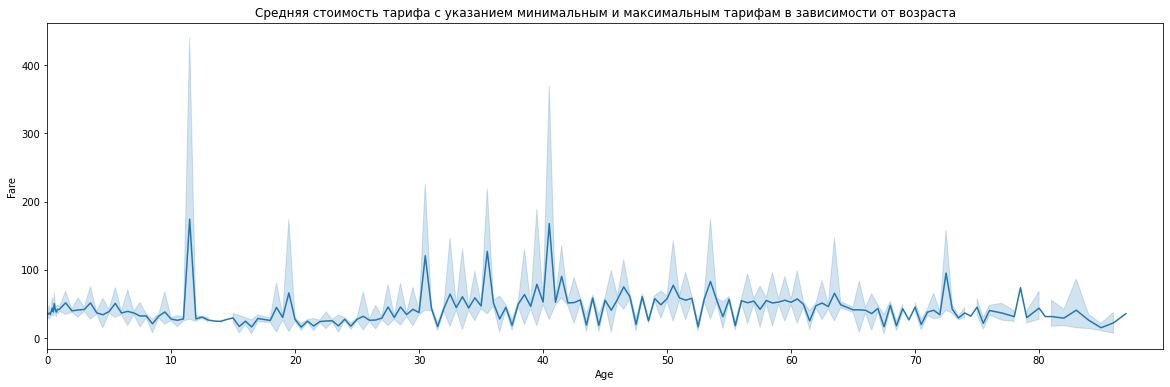

Из представленного выше графика можно сделать вывод, что пассажиры в возрасте от 30 до 55 являются самыми платежеспособными гражданами. При этом наблюдаются пики тарифа для восрастов около 41 и 12 лет.


In [52]:
print('')

plt.figure(figsize=(20, 6))
plt.title('Средняя стоимость тарифа с указанием минимальным '
          'и максимальным тарифам в зависимости от возраста')

age_fare_fig = sb.lineplot(x='Age', y='Fare',
      data=syntanic_data[['Fare', 'Age']].dropna())
age_fare_fig.set_xticks(list(range(0, 90, 10)), labels=list(range(0, 90, 10)))
age_fare_fig.set_xlim(0, 90)
plt.show()

print('Из представленного выше графика можно сделать вывод, '
      'что пассажиры в возрасте от 30 до 55 являются самыми '
      'платежеспособными гражданами. При этом наблюдаются '
      'пики тарифа для восрастов около 41 и 12 лет.')

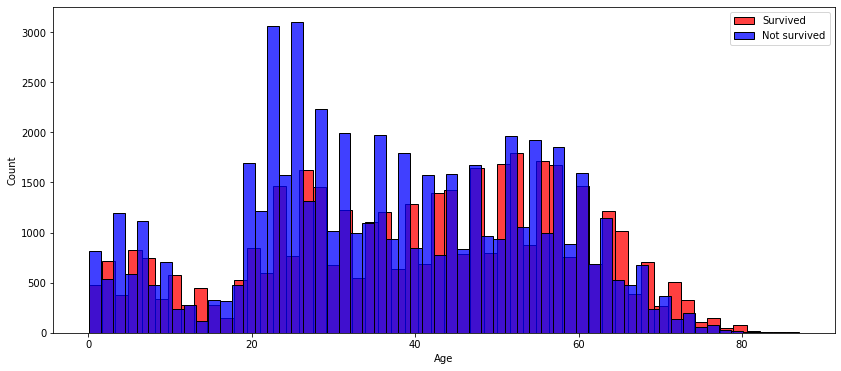

In [53]:
plt.figure(figsize=(14, 6))


age_surv_plot: plt.Axes = sb.histplot(
      data=syntanic_data[syntanic_data['Survived'] == 1]['Age'], label='Survived',
      color='Red'
)
sb.histplot(
      data=syntanic_data[syntanic_data['Survived'] == 0]['Age'], label='Not survived',
      color='Blue'
)

plt.legend()
plt.show()

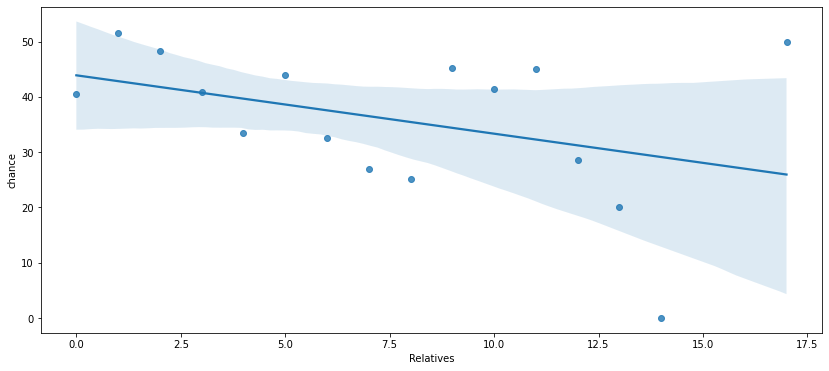

,Relatives,chance
0,0.0,40.439429
1,1.0,51.625387
2,2.0,48.243581
3,3.0,40.919410
4,4.0,33.529412
5,5.0,44.034537
6,6.0,32.530120
7,7.0,26.923077
8,8.0,25.225225
9,9.0,45.222930


In [83]:
surv_rel_data = pd.DataFrame(columns=['Relatives', 'chance'])

for i in range(syntanic_data['Relatives'].max() + 1):
      relatives_pass_count = syntanic_data[syntanic_data['Relatives'] == i].shape[0]
      relatives_pass_surv_count = syntanic_data[
            (syntanic_data['Relatives'] == i) & (syntanic_data['Survived'] == 1)].shape[0]
      if relatives_pass_count != 0:
            surv_rel_data.loc[i] = i, (relatives_pass_surv_count / relatives_pass_count) * 100

plt.figure(figsize=(14, 6))
surv_rel_plot: plt.Axes = sb.regplot(
      x=surv_rel_data['Relatives'], y=surv_rel_data['chance']
)
plt.show()

surv_rel_data

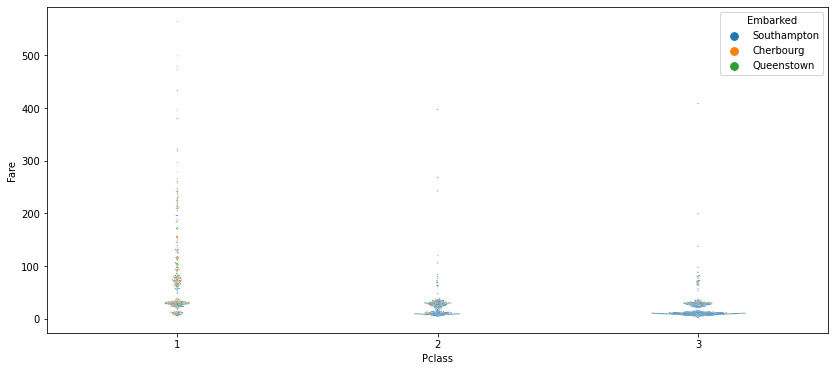

In [55]:
plt.figure(figsize=(14, 6))
class_price_fig = sb.swarmplot(
      x='Pclass', y='Fare', hue='Embarked', s=1,
      data=syntanic_data[syntanic_data['Fare'].notna() & syntanic_data['Embarked'].notna()].head(1000)
)

# Summary